In [ ]:
!pip install pycausalimpact

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind, binomtest, chi2_contingency, bootstrap, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

### AB testing and experimentation

Let's look at a dataset from a mobile game called "COOKIE CATS". The designers were testing if moving the difficulty gate from level 30 to 40 would change retention and time played within game.

Retention is basically who still plays the game `x` days after installing it

In [ ]:
cc_df = pd.read_csv('https://raw.githubusercontent.com/yufung/ab-testing-cookie-cats/master/data/cookie_cats.csv')

Let's take a look at the data, we have two groups game_30 and gate_40

In [ ]:
cc_df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7,counter
0,116,gate_30,3,False,False,1
1,337,gate_30,38,True,False,1
2,377,gate_40,165,True,False,1
3,483,gate_40,1,False,False,1
4,488,gate_40,179,True,True,1


Let's look at some descriptive stats

In [ ]:
version_stats = cc_df.groupby('version').agg(d1_ret = ('retention_1', 'mean'), d7_ret = ('retention_7', 'mean'), avg_rounds = ('sum_gamerounds', 'mean'), n = ('userid', 'count'))

In [ ]:
version_stats

,d1_ret,d7_ret,avg_rounds,n
version,,,,
gate_30,0.448188,0.190201,52.456264,44700
gate_40,0.442283,0.182000,51.298776,45489


Woah we have some outliers

(array([9.0188e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,  4985.4,  9970.8, 14956.2, 19941.6, 24927. , 29912.4,
        34897.8, 39883.2, 44868.6, 49854. ]),
 <BarContainer object of 10 artists>)

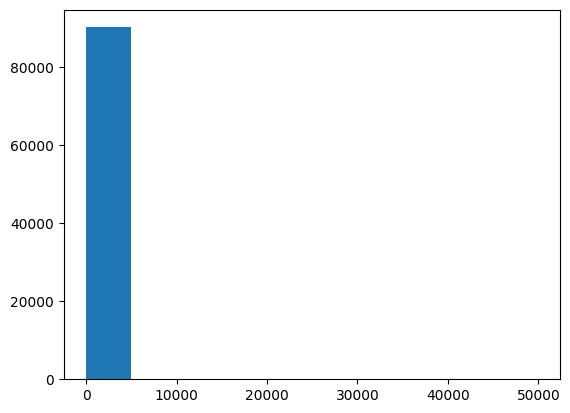

In [ ]:
plt.hist(cc_df['sum_gamerounds'])

In [ ]:
group30 = cc_df[cc_df.version == 'gate_30']
group40 = cc_df[cc_df.version == 'gate_40']

Let's try a t test to compare the means of the two groups. The t-test has FAT TAILS which means it is outlier resilant but it assumes that the samples of the means from a distribution are somewhat normal

In [ ]:
ttest_result = ttest_ind(group30['sum_gamerounds'].values, group40['sum_gamerounds'].values)
print(ttest_result)

TtestResult(statistic=0.8910426211362967, pvalue=0.37290868247405207, df=90187.0)


In [ ]:
mwu_result = mannwhitneyu(group30['sum_gamerounds'].values, group40['sum_gamerounds'].values, method="asymptotic")
print(mwu_result)

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)


Result conditional on sample size. Power and effect.

In [ ]:
ttest_result = ttest_ind(np.repeat(group30['sum_gamerounds'].values, 500), np.repeat(group40['sum_gamerounds'].values, 500))
print(ttest_result)

TtestResult(statistic=19.924539196330684, pvalue=2.4954983354699164e-88, df=45094498.0)


We can also test rates

In [ ]:
cc_df['counter'] = 1

In [ ]:
binom_data = cc_df.groupby('version').sum().reset_index()

In [ ]:
r1_data = binom_data[['retention_1', 'counter']].values
r7_data = binom_data[['retention_7', 'counter']].values

In [ ]:
r1_results = chi2_contingency(r1_data)
print(r1_results)

Chi2ContingencyResult(statistic=1.2086177699867586, pvalue=0.27160604187550974, dof=1, expected_freq=array([[19941.87830477, 44792.12169523],
       [20211.12169523, 45396.87830477]]))


In [ ]:
r1_data -  r1_results[3]

array([[ 92.12169523, -92.12169523],
       [-92.12169523,  92.12169523]])

In [ ]:
r7_results = chi2_contingency(r7_data)
print(r7_results)

Chi2ContingencyResult(statistic=6.827182523173922, pvalue=0.00897807778766914, dof=1, expected_freq=array([[ 8346.10416004, 44855.89583996],
       [ 8434.89583996, 45333.10416004]]))


In [ ]:
r7_data -  r7_results[3]

array([[ 155.89583996, -155.89583996],
       [-155.89583996,  155.89583996]])

Repeated testing increases the odd of a false positive

In [ ]:
def sub_sampler(df, version_var, group1, group2, target_var, trials, prop, p_thresh):
    holder = []
    for trial in range(0, trials):
      sample_data = df.sample(frac = prop)
      samp1 = sample_data[sample_data[version_var] == group1]
      samp2 = sample_data[sample_data[version_var] == group2]
      ttest_result = ttest_ind(samp1[target_var], samp2[target_var])
      p_val = ttest_result[1]
      holder.append(p_val)
    h_array = np.array(holder)
    sig = h_array[h_array <= p_thresh]
    hit_rate = len(sig)/len(h_array)
    return(hit_rate, h_array)



In [ ]:
hit_rate, p_vals = sub_sampler(cc_df, 'version', 'gate_30', 'gate_40', 'sum_gamerounds', 100, 0.15, 0.05)

In [ ]:
print(hit_rate)

0.05


In [ ]:
print(p_vals)

[0.54089921 0.01723744 0.76259252 0.42817434 0.82019065 0.20992687
 0.05513717 0.28638626 0.17202364 0.39547059 0.1799667  0.38335642
 0.34989346 0.21027046 0.30680126 0.10384595 0.74425151 0.23474145
 0.69567433 0.35889344 0.40207112 0.75325271 0.10564485 0.79135099
 0.89213319 0.8727285  0.60268195 0.66085575 0.68302902 0.14707196
 0.78773975 0.34124849 0.56921935 0.39731572 0.04916598 0.42297815
 0.89113953 0.43544639 0.93703883 0.37168049 0.4768896  0.73097407
 0.00757171 0.84204385 0.02498846 0.3474615  0.26262458 0.32802187
 0.23096448 0.71087603 0.87227654 0.60762163 0.23000586 0.54433418
 0.77013181 0.105281   0.24808769 0.13640484 0.61768357 0.3279633
 0.58430761 0.29682941 0.47500164 0.36307127 0.26745443 0.40777193
 0.75905219 0.29118182 0.37144311 0.41856278 0.72550173 0.16761854
 0.56732415 0.57378122 0.60456981 0.62916272 0.72249756 0.6324386
 0.62061892 0.69261452 0.0515939  0.35320312 0.42089153 0.5623498
 0.8907745  0.19296336 0.15234589 0.23348367 0.1266757  0.6153974

In [ ]:
print(p_vals[p_vals < 0.05])

[0.01723744 0.04916598 0.00757171 0.02498846 0.03091918]


Bootstrapping is an alternative way to do this.

In [ ]:
g30_boot = bootstrap((group30['sum_gamerounds'].values,), np.mean,  n_resamples = 500, batch = 50)
g40_boot = bootstrap((group40['sum_gamerounds'].values,), np.mean, n_resamples = 500, batch = 50)

In [ ]:
g30_boot.confidence_interval

ConfidenceInterval(low=50.9915039318559, high=57.0166369171526)

In [ ]:
g40_boot.confidence_interval

ConfidenceInterval(low=50.468210068624835, high=52.33655792418126)

In [ ]:
g30_samps = pd.DataFrame(g30_boot.bootstrap_distribution, columns = ['samples'])
g30_samps['condition'] = 'g30'
g40_samps = pd.DataFrame(g40_boot.bootstrap_distribution, columns = ['samples'])
g40_samps['condition'] = 'g40'

In [ ]:
all_samps = pd.concat([g30_samps, g40_samps], axis = 0)

<Axes: xlabel='samples', ylabel='Count'>

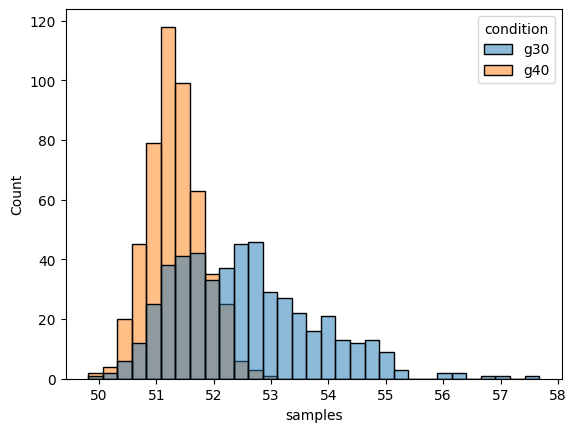

In [ ]:
sns.histplot(all_samps, x = 'samples', hue = 'condition')

Can boostrap most statistics or even test measures.

Another school is Bayesian stats, this simulates alterantive realities instead of sampling

In [ ]:
binom_data['codes'] = pd.factorize(binom_data['version'])[0]

In [ ]:
binom_data

,version,userid,sum_gamerounds,retention_1,retention_7,counter,codes
0,gate_30,222944098441,2344795,20034,8502,44700,0
1,gate_40,227857702576,2333530,20119,8279,45489,1


In [ ]:
codes = binom_data['codes'].values

In [ ]:
with pm.Model() as model_d1:
  beta = pm.Beta('beta', 1,1, shape = 2)
  obs = pm.Binomial('obs', p = beta, n = binom_data.counter[codes], observed = binom_data.retention_1[codes])
  trace = pm.sample()

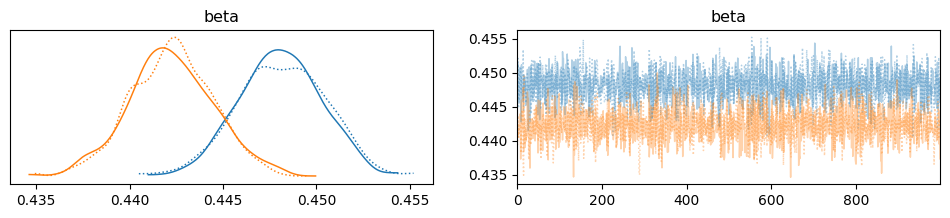

In [ ]:
with model_d1:
  pm.plot_trace(trace)

In [ ]:
with model_d1:
  results_d1 = pm.summary(trace, hdi_prob = 0.95)

In [ ]:
results_d1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.448,0.002,0.444,0.452,0.0,0.0,2185.0,1460.0,1.0
beta[1],0.442,0.002,0.438,0.447,0.0,0.0,2192.0,1562.0,1.0


In [ ]:
with pm.Model() as model_d7:
  beta = pm.Beta('beta', 1,1, shape = 2)
  obs = pm.Binomial('obs', p = beta, n = binom_data.counter[codes], observed = binom_data.retention_7[codes])
  trace_d7 = pm.sample()

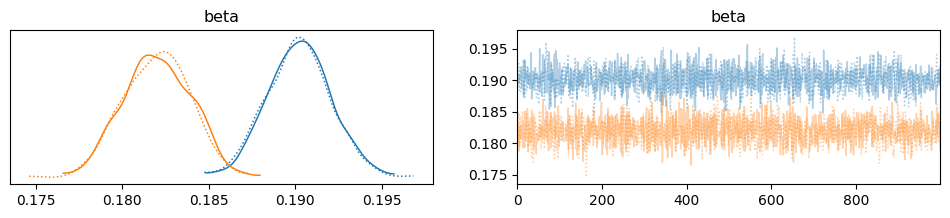

In [ ]:
with model_d7:
  pm.plot_trace(trace_d7)

In [ ]:
with model_d7:
  results_d7 = pm.summary(trace_d7, hdi_prob = 0.95)

In [ ]:
results_d7

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.190,0.002,0.187,0.194,0.0,0.0,1965.0,1538.0,1.0
beta[1],0.182,0.002,0.179,0.186,0.0,0.0,1869.0,1667.0,1.0


If we don't have a control group we can simulate one with bayesian methods.

In [ ]:
from causalimpact import CausalImpact


data = pd.read_csv('https://raw.githubusercontent.com/WillianFuks/tfcausalimpact/master/tests/fixtures/comparison_data.csv', index_col=['DATE'])
pre_period = ['2019-04-16', '2019-07-14']
post_period = ['2019-7-15', '2019-08-01']
ci = CausalImpact(data, pre_period, post_period, model_args={'fit_method': 'hmc'})

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: standardize, model_args, nseasons. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:4

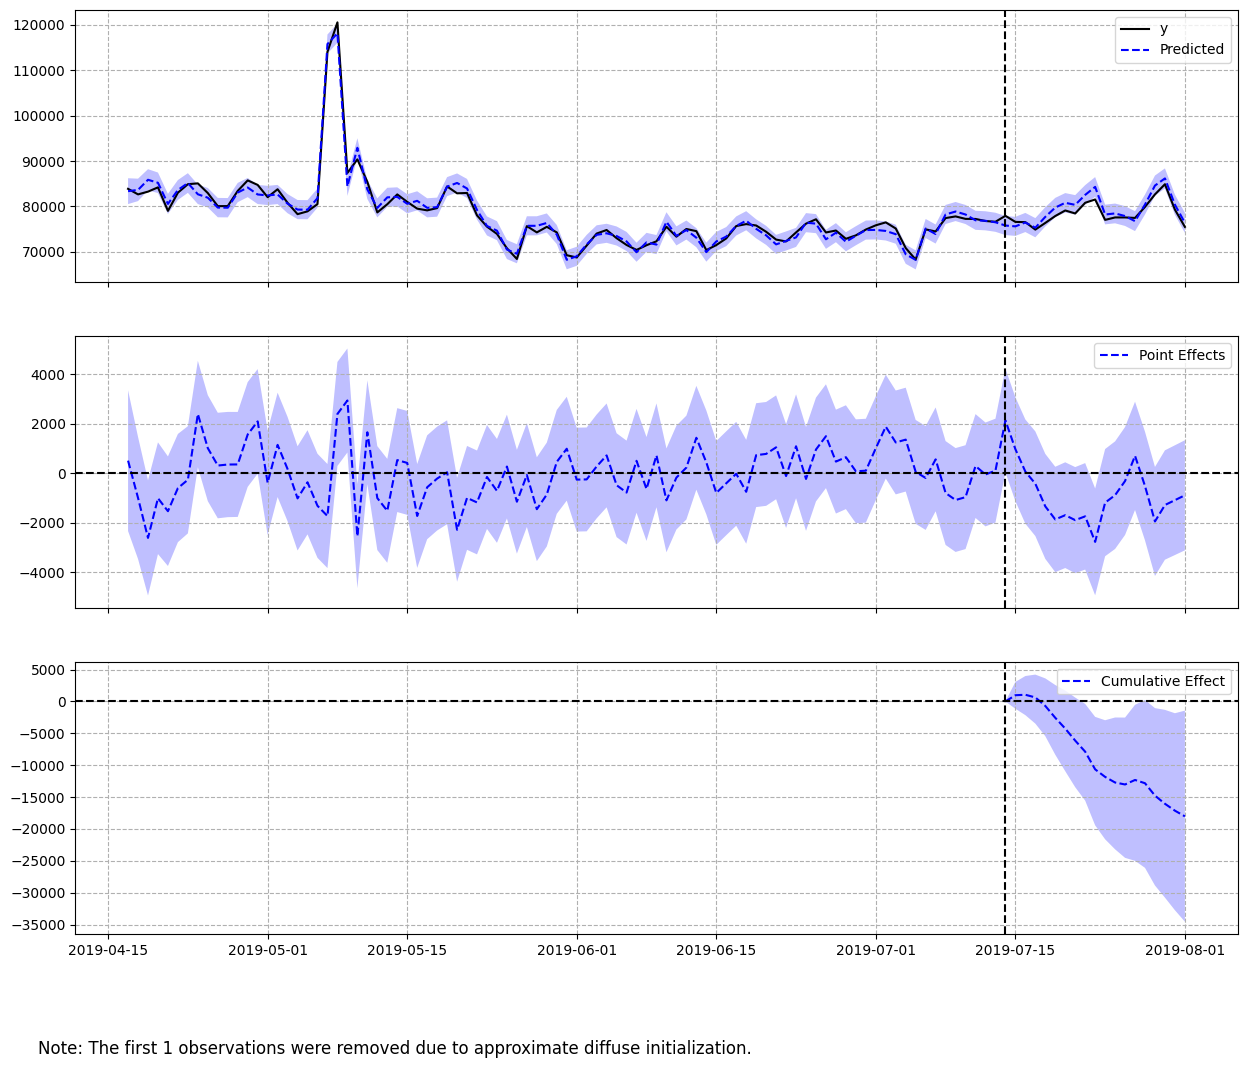

In [ ]:
ci.plot()

In [ ]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 78574.42. By contrast, in the absence of an
intervention, we would have expected an average response of 79575.72.
The 95% interval of this counterfactual prediction is [78654.64, 80493.81].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -1001.3 with a 95% interval of
[-1919.39, -80.22]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1414339.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1432362.89. The 95% interval of this prediction is [1415783.45, 1448888.49].


The above results are given in terms of absolute numbers. In re